In [1]:
import os
import sys
from os import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
import json
import argparse
from scipy.optimize import least_squares
import coord_helper as ch
import h5py
import importlib

BDC is using numpy


In [25]:
#config_file_name1 = 'config_1721800002.json'
#config_file_name2 = 'config_1721900002.json'
config_file_name1 = 'config_24_07.json'
config_file_name2 = 'config_25_07.json'
baseline_idx = 1
working_directory = '/project/s/sievers/thomasb/mars_data_24/4bit'
day1 = '24_07'
day2 = '25_07'

In [26]:
with open(f"{working_directory}/{day1}/{config_file_name1}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)
print(global_start_time)

Antenna Paths: ['/scratch/s/sievers/mohanagr/mars1_2024/baseband/', '/scratch/s/sievers/mohanagr/mars2_2024/baseband/']
Antenna Coordinates: [[79.41718333333333, -90.76735, 189], [79.41721666666666, -90.75885, 176]]
Visibility Accumulation Length 30000
Coarse Accumulation Length: 1000000
1721797200


In [27]:
with open(f"{working_directory}/{day2}/{config_file_name2}", "r") as f:
    config = json.load(f)
    global_start_time2 = config["correlation"]["start_timestamp"]


In [28]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path = dir_parents[0]
a2_path = dir_parents[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")
tle_path2 = outils.get_tle_file(global_start_time2, "/project/s/sievers/mohanagr/OCOMM_TLES")


context = [visibility_window, T_SPECTRA, v_acclen, v_nchunks, ref_coords]
print(global_start_time)

1721797200


In [29]:
pulse_list_1 = []

with h5py.File(f'{working_directory}/{day1}/vis_selected_bline_{baseline_idx}_{global_start_time}.h5', 'r') as f:
    for p in f:
        pulse_info = []
        pulse_info.append(p)
        pulse_info.append([int(f[p].attrs['start_time']), int(f[p].attrs['end_time']), int(f[p].attrs['global_start_time'])])
        pulse_info.append([int(f[p].attrs['sat']), int(f[p].attrs['chan'])])
        pulse_info.append(f[p].attrs['tle_path'])
        pulse_info.append(f[f'/{p}'][:])
        pulse_list_1.append(pulse_info)
print(pulse_list_1)
print("number of pulses present:", len(pulse_list_1))

#note here that they keep the same index label from the earlier full raw data dump
#idea is that this will facilitate tracebacks for debugs

[['0_0', [0, 150, 1721797200], [33591, 1850], '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt', array([  0.        ,   0.53603125,   1.0332818 ,   1.3672576 ,
         1.970387  ,   2.4686203 ,   2.9918547 ,   3.509241  ,
         4.092124  ,   4.6418915 ,   5.0497932 ,   5.4193764 ,
         6.011     ,   6.4475317 ,   6.8997    ,   7.34048   ,
         7.8800764 ,   8.206408  ,   8.606661  ,   9.051219  ,
         9.56092   ,  10.032917  ,  10.537008  ,  11.129764  ,
        11.616804  ,  11.985176  ,  12.494032  ,  12.90781   ,
        13.400068  ,  13.79236   ,  14.217382  ,  14.717305  ,
        15.295628  ,  15.870983  ,  16.336153  ,  16.790314  ,
        17.27932   ,  17.83482   ,  18.305643  ,  18.928213  ,
        19.497387  ,  20.088642  ,  20.54544   ,  21.173803  ,
        21.66172   ,  22.088806  ,  22.56815   ,  23.186474  ,
        23.79163   ,  24.358734  ,  24.942879  ,  25.484608  ,
        25.915985  ,  26.510254  ,  27.096535  ,  27.653173  ,
     

In [30]:
importlib.reload(ch)

<module 'coord_helper' from '/home/s/sievers/thomasb/albatros_analysis/scripts/orbcomm/fitting/coord_helper.py'>

catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC


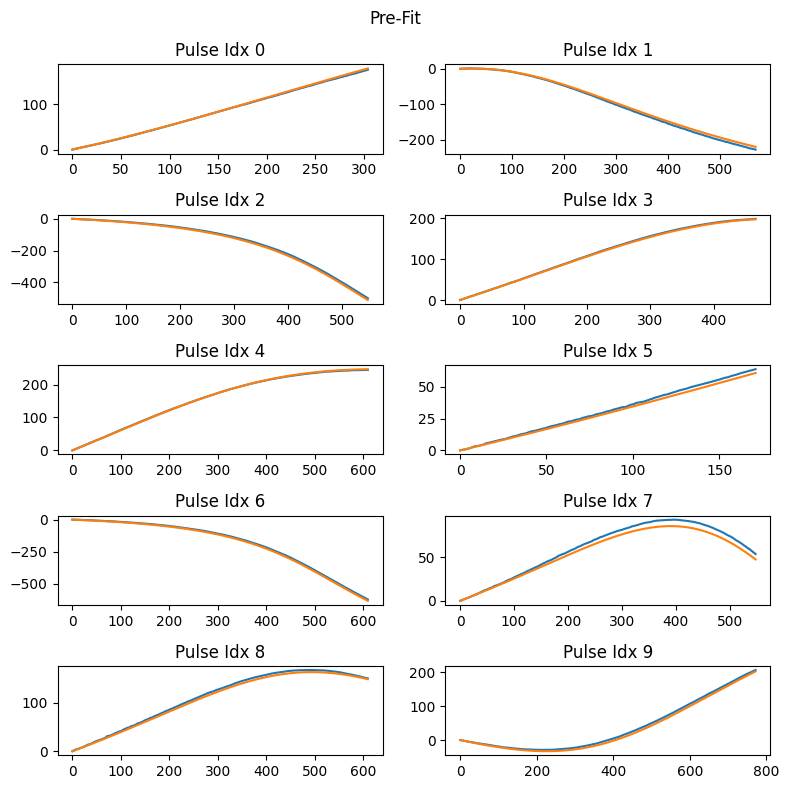

In [31]:
#just the first 10

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit")
for pulse_idx in range(10):
    predicted_data = ch.phase_pred(a2_coords, pulse_idx, pulse_list_1, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_list_1[pulse_idx][4])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC


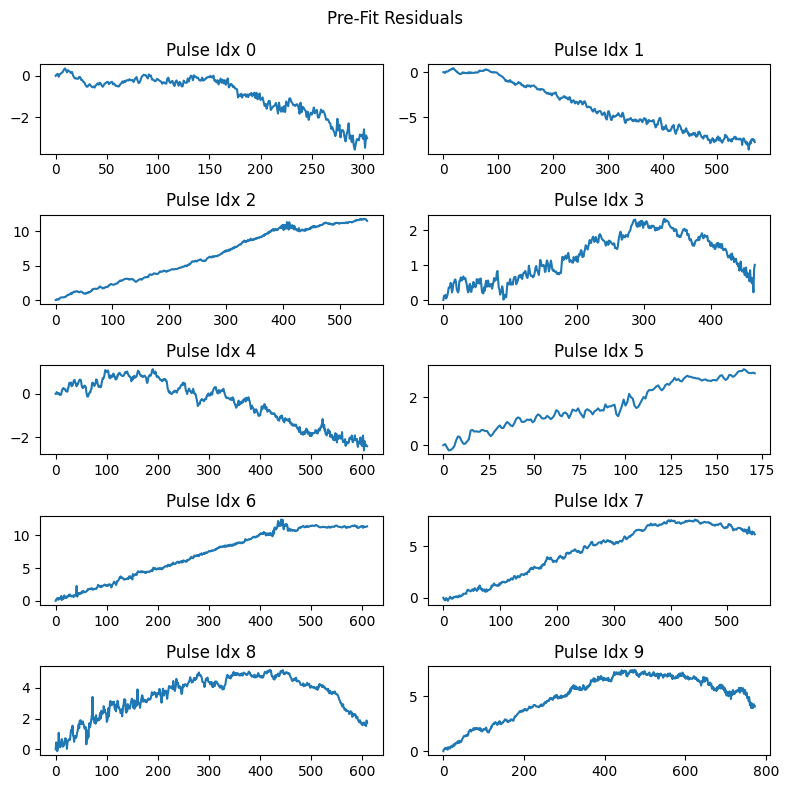

In [32]:
#again first 10

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit Residuals")
for pulse_idx in range(10):
    predicted_data = ch.phase_pred(a2_coords, pulse_idx, pulse_list_1, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_list_1[pulse_idx][4] - predicted_data)
plt.tight_layout()

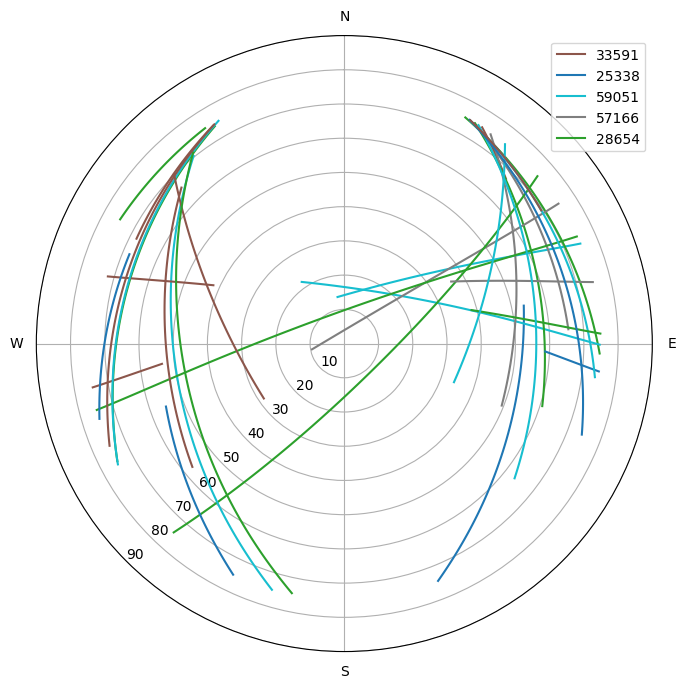

In [33]:
ch.satpass_plotter(pulse_list_1, a2_coords)

In [39]:
guess = [a2_coords[0], a2_coords[1], 183]

In [40]:
solid1 = ch.fitting_all(a2_coords, ch.phase_pred, pulse_list_1, context)[0]

catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #2

In [41]:
print(solid1)

[ 79.41722675 -90.7588766  183.32516793]


In [42]:
ch.distance_calculator(a2_coords, solid1)

(1.2450830894296492, 7.325167931150929)

SECOND DAY

In [43]:
pulse_list_2 = []

with h5py.File(f'{working_directory}/{day2}/vis_selected_bline_1_{global_start_time2}.h5', 'r') as f:
    for p in f:
        pulse_info = []
        pulse_info.append(p)
        pulse_info.append([int(f[p].attrs['start_time']), int(f[p].attrs['end_time']), int(f[p].attrs['global_start_time'])])
        pulse_info.append([int(f[p].attrs['sat']), int(f[p].attrs['chan'])])
        pulse_info.append(f[p].attrs['tle_path'])
        pulse_info.append(f[f'/{p}'][:])
        pulse_list_2.append(pulse_info)
print(pulse_list_2)
print(len(pulse_list_2))

[['0_2740', [2740, 3140, 1721883602], [28654, 1836], '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240725.txt', array([ 0.00000000e+00, -2.35862494e-01, -1.97705984e-01, -5.63644886e-01,
       -8.89379263e-01, -1.17901111e+00, -1.61661017e+00, -1.75821495e+00,
       -2.05005550e+00, -2.31700778e+00, -2.61657691e+00, -2.85584664e+00,
       -3.13210464e+00, -3.42136550e+00, -3.62915468e+00, -4.01979828e+00,
       -4.08757067e+00, -4.40512276e+00, -4.62463331e+00, -4.91420603e+00,
       -5.16626358e+00, -5.52003956e+00, -5.86833000e+00, -6.10495758e+00,
       -6.31303120e+00, -6.61682987e+00, -6.63640451e+00, -6.96049881e+00,
       -7.16017342e+00, -7.37309504e+00, -7.70100069e+00, -7.97964287e+00,
       -8.11494350e+00, -8.53498936e+00, -8.80312347e+00, -9.02519798e+00,
       -9.29168320e+00, -9.50544548e+00, -9.73054028e+00, -1.00712662e+01,
       -1.02787151e+01, -1.05256853e+01, -1.05808039e+01, -1.08112669e+01,
       -1.11663370e+01, -1.14777126e+01, -1.17591314e+0

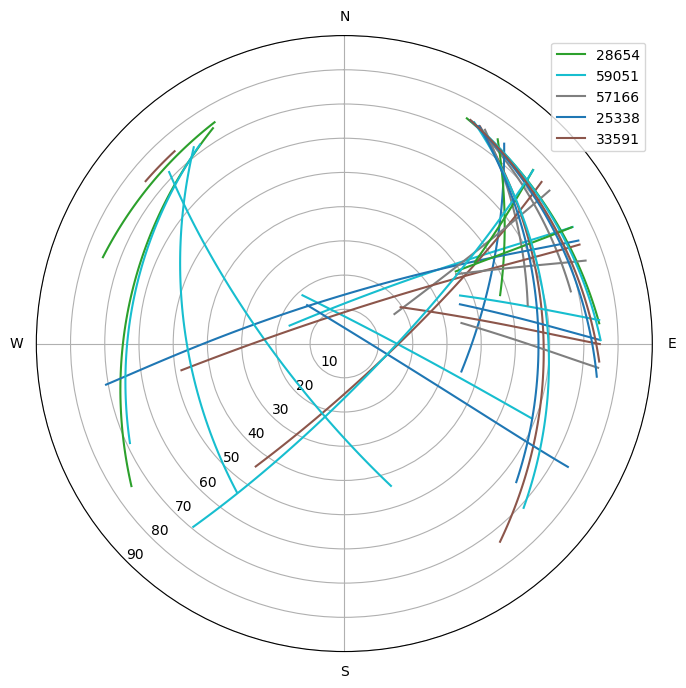

In [44]:
ch.satpass_plotter(pulse_list_2, a2_coords)

In [45]:
solid2 = ch.fitting_all(a2_coords, ch.phase_pred, pulse_list_2, context)[0]

catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #57166 epoch 2024-07-25 21:41:50 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #57166 epoch 2024-07-25 21:41:50 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #57166 epoch 2024-07-25 21:41:50 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #57166 epoch 2024-07-25 21:41:50 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #2

In [46]:
print(solid2)

[ 79.41721575 -90.75882419 181.51716959]


In [47]:
ch.distance_calculator(solid1, solid2)

(1.624274508278772, 1.807998341301328)

In [48]:
pulse_all = pulse_list_1 + pulse_list_2

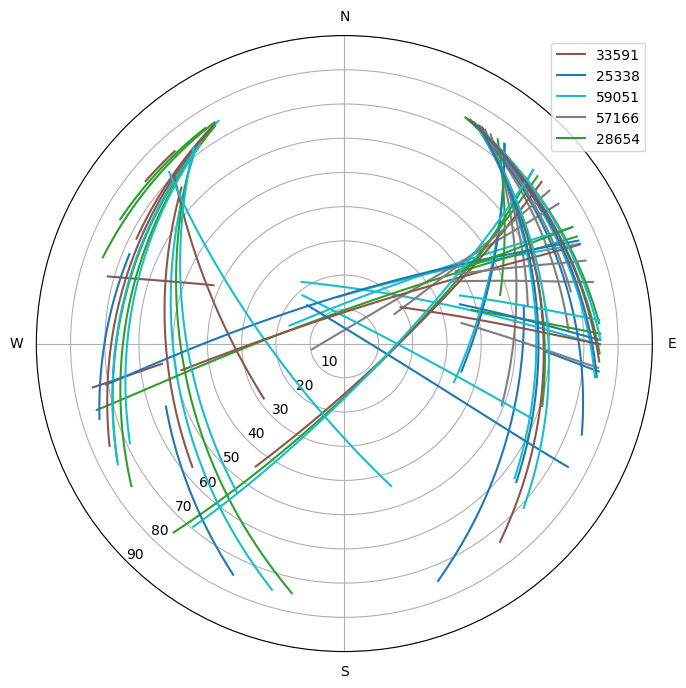

In [76]:
ch.satpass_plotter(pulse_all, a2_coords)


In [50]:
solidall = ch.fitting_all(guess, ch.phase_pred, pulse_all, context)[0]

catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #57166 epoch 2024-07-24 22:05:12 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #2

In [51]:
print(solidall)

[ 79.41722209 -90.75884386 182.54894264]


In [52]:
ch.distance_calculator(solidall, solid1)

(0.8450911434198092, 0.7762252866738777)

In [53]:
ch.distance_calculator(solidall, solid2)

(0.8111878541653855, 1.0317730546274504)

In [70]:
importlib.reload(ch)

<module 'coord_helper' from '/home/s/sievers/thomasb/albatros_analysis/scripts/orbcomm/fitting/coord_helper.py'>

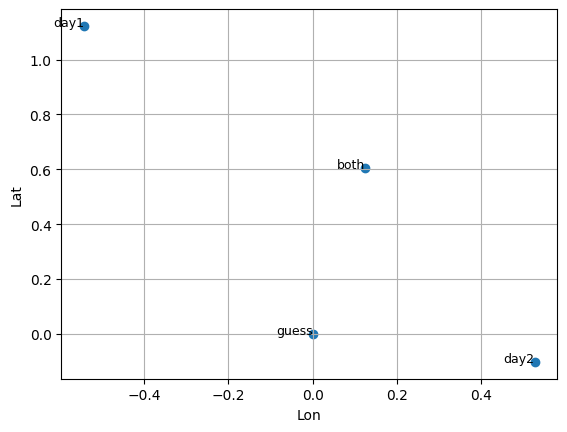

In [74]:
day1_lat_m, day1_lon_m, _ = ch.dist_components(a2_coords, solid1)
day2_lat_m, day2_lon_m, _ = ch.dist_components(a2_coords, solid2)
all_lat_m, all_lon_m, _ = ch.dist_components(a2_coords, solidall)

lats = [0, day1_lat_m, day2_lat_m, all_lat_m]
lons = [0, day1_lon_m, day2_lon_m, all_lon_m]

labels = ['guess', 'day1', 'day2', 'both']

# Basic scatter plot
plt.scatter(lons, lats)

# Add labels directly at each point
for lon, lat, label in zip(lons, lats, labels):
    plt.text(lon, lat, label, fontsize=9, ha='right')

plt.xlabel("Lon")
plt.ylabel("Lat")
plt.grid(True)
plt.show()
